In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import rasterio as rio
from rasterio.plot import show
import re
import requests
import json
import math
from shapely.geometry import *
from rasterio import mask
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from rasterio.enums import Resampling
from scipy import misc
import time
import sys

In [2]:
project_path = os.path.abspath(os.path.join("readfiles.ipynb", os.pardir, os.pardir))
data_path = os.path.join(project_path, "Data")

external_data_path = "/media/seppe/DiskSpaceInvader/3DHouseData"

lookup_panda = pd.read_csv(os.path.join(project_path, "overviewdataframe.csv"))

In [3]:
class AddressError(Exception):
    pass

def address_lookup(addr:str, debug=False):
    req = requests.get(f"http://loc.geopunt.be/geolocation/location?q={addr}&c=1",)
    ret_dict = {}
    if req.json()["LocationResult"] == []:
        raise AddressError("That address couldn't be recognized, please try again with a different string.")
    for k,v in req.json()["LocationResult"][0].items():
        if debug: print(f"{k}: {v}")
        ret_dict[k] = [v]
    return ret_dict

In [4]:
## Hedia's polygon API
def hedi_api(address:dict, debug=False):
    street = address['Thoroughfarename'][0]
    nb = address['Housenumber'][0]
    pc = address['Zipcode'][0]
    city = address['Municipality'][0]
    if debug: print(street,nb,city,pc)
    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/adresmatch?gemeentenaam={city}&straatnaam={street}&huisnummer={nb}&postcode={pc}").json()
    objectId = req["adresMatches"][0]["adresseerbareObjecten"][0]["objectId"]

    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouweenheden/{objectId}").json()
    objectId = req["gebouw"]["objectId"]

    req = requests.get(f"https://api.basisregisters.dev-vlaanderen.be/v1/gebouwen/{objectId}").json()
    polygon = [req["geometriePolygoon"]["polygon"]]
    if debug: print(polygon)
    return polygon

def show_polygon(poly):
    for n in poly:
        loc = n['coordinates'][0]
        x,y = [],[]
        for i in range(len(loc)):
            x.append(loc[i][0])
            y.append(loc[i][1])
        fig, ax = plt.subplots(1, figsize=(20, 20))
        ax.set_aspect('equal')
        plt.plot(x, y, scalex=1, scaley=1)
        plt.show

In [5]:
def find_tiles(tile_panda, address_poly, debug=False):
    
    results = []
    
    # Weird loop to check the bounds of every polygon, 
    # assuming that there might be more polygon's for a single estate or something?
    for n in address_poly:
        points = n['coordinates'][0]

        left = points[0][0]
        bottom = points[0][1]
        right = points[0][0]
        top = points[0][1]

        for point in points:
            left = min(left, point[0])
            right = max(right, point[0])
            bottom = min(bottom, point[1])
            top = max(top, point[1])

        if debug: print(left, bottom, right, top)
        for row in tile_panda.itertuples():
            if row.left_bound < left < row.right_bound and row.bottom_bound < bottom < row.top_bound:
                if debug: print(f"Found LowerLeft")
                if row not in results:
                    results.append(row)
            if row.left_bound < right < row.right_bound and row.bottom_bound < top < row.top_bound:
                if debug: print(f"Found UpperRight")
                if row not in results:
                    results.append(row)
    if debug:
        fig, axes = plt.subplots(len(results),1, figsize=(12, 12))
        for i in range(len(results)):
            tif = results[i].file_path
            tif_im = rio.open(tif)
            show(tif_im, ax=axes[i])
        plt.show()
    # I will probably regret the decision to return this weird list later on. Too bad ...
    return (results, (left, bottom, right, top))

In [6]:
def auto_mask(tile_panda, tifs, poly, address, debug=False):
    if 'DSM' in tifs[0][0].file_path:
        dsm_pd = tifs[0][0]
        dtm_pd = tifs[0][1]
    else:
        dsm_pd = tifs[0][1]
        dtm_pd = tifs[0][0]
    shapes = [Polygon(poly[0]['coordinates'][0])]
    masked_dsm_path = address + "_masked_dsm.tif"
    masked_dtm_path = address + "_masked_dtm.tif"
    with rio.open(dsm_pd.file_path) as dsm:
        out_image, out_transform = mask.mask(dsm, shapes, crop=True, nodata=0, filled=True)
        out_meta = dsm.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rio.open(masked_dsm_path, "w", **out_meta) as dest:
            dest.write(out_image)
            if debug: print("Saved masked_dsm.tif")
    with rio.open(dtm_pd.file_path) as dtm:
        out_image, out_transform = mask.mask(dtm, shapes, crop=True, nodata=0, filled=True)
        out_meta = dtm.meta
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform})
        with rio.open(masked_dtm_path, "w", **out_meta) as dest:
            dest.write(out_image)
            if debug: print("Saved masked_dtm.tif")
    return [masked_dsm_path, masked_dtm_path]

In [7]:
def plot_building(mask_paths, upscale_factor=2,debug=False):
    dsm = rio.open(mask_paths[0])
    dtm = rio.open(mask_paths[1])
    
    dsm_im = dsm.read(1, masked=True, out_shape=(
        dsm.count,
        int(dsm.height * upscale_factor),
        int(dsm.width * upscale_factor)),
                      resampling=Resampling.bilinear)
    # scale image transform
    transform = dsm.transform * dsm.transform.scale(
        (dsm.width / dsm.shape[-1]),
        (dsm.height / dsm.shape[-2])
    )

    dtm_im = dtm.read(1, masked=True, out_shape=(
        dtm.count,
        int(dtm.height * upscale_factor),
        int(dtm.width * upscale_factor)),
                      resampling=Resampling.bilinear)
    # scale image transform
    transform = dtm.transform * dtm.transform.scale(
        (dtm.width / dtm.shape[-1]),
        (dtm.height / dtm.shape[-2])
    )

    # Are the bounds the same?
    if debug: print("Is the spatial extent the same?", dsm.bounds == dtm.bounds)

    # Is the resolution the same ??
    if debug: print("Is the resolution the same?", dsm.res == dtm.res)

    dem_im = dsm_im - dtm_im

    x_list = np.arange(0, dem_im.shape[1])
    y_list = np.arange(0, dem_im.shape[0])
    z = dem_im

    x_grid, y_grid = np.meshgrid(x_list, y_list)
    fig = plt.figure(figsize=(20,20))
    ax = plt.axes(projection="3d")

    ax.plot_surface(x_grid,y_grid,z,cmap='afmhot')

    plt.show()
    return

In [8]:
def house_plot(debug=False):
    start_time = time.time()
    address_str = input("Which address would you like to plot in 3D?")
    my_address = address_lookup(address_str,debug)
    my_poly = hedi_api(my_address, debug)
    if debug: show_polygon(my_poly)
    my_tifs = find_tiles(lookup_panda, my_poly, debug)
    masks = auto_mask(lookup_panda, my_tifs, my_poly, address_str, debug)
    plot_building(masks,2,debug)
    end_time = time.time()
    print(f"Elapsed time: {round(end_time-start_time, 2)} seconds")
    if input("Would you like to start again? (y|n)") == 'y':
        return house_plot(debug)
    else:
        return
    
    

Which address would you like to plot in 3D?Esptweg 55 Leest


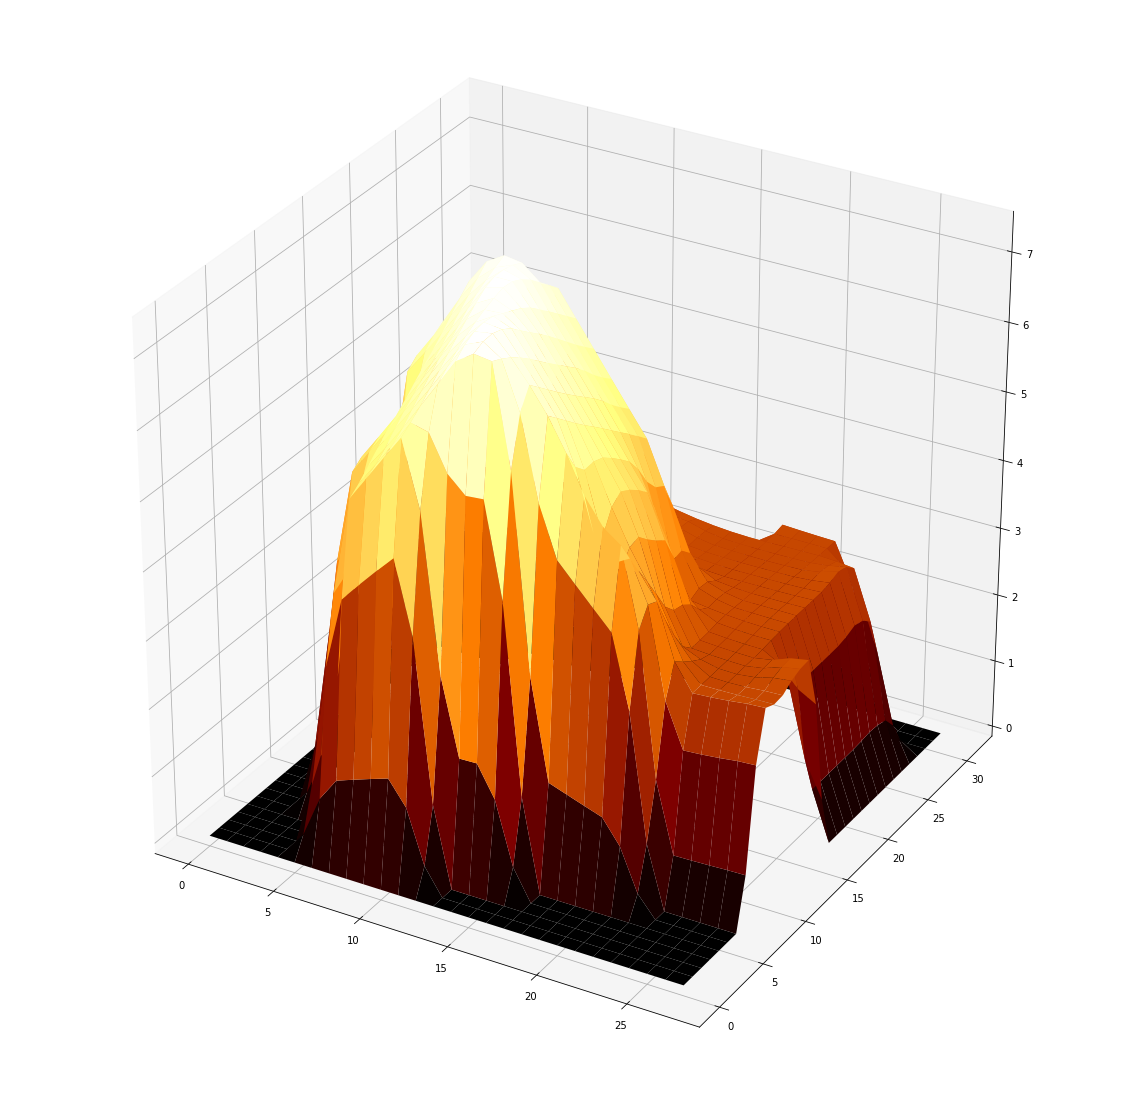

Elapsed time: 9.48 seconds


In [ ]:
house_plot()